### **Maximum Independent Set**

In [13]:
## import necessary libraries
import os
import json 
import glob

import networkx as nx
import matplotlib.pyplot as plt

In [14]:
from docplex.mp.model import Model
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo

**Helper Functions**

In [15]:
def read_graph_from_file(file_path):
    """
    Reads a graph from a text file and returns the number of nodes, edges, and edge list.

    Parameters:
    - file_path: str, path to the text file containing the graph definition.

    Returns:
    - num_nodes: int, number of nodes in the graph.
    - edges: list of tuple, list of edges in the graph.
    """
    edges = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] == 'p':
                num_nodes = int(parts[2])
                num_edges = int(parts[3])
            elif parts[0] == 'e':
                u = int(parts[1]) - 1  # Convert to 0-based index
                v = int(parts[2]) - 1  # Convert to 0-based index
                edges.append((u, v))
    return num_nodes, edges

def create_max_independent_set_model(num_nodes, edges):
    """
    Creates a CPLEX model for the Maximum Independent Set (MIS) problem.

    Parameters:
    - num_nodes: int, the number of nodes in the graph.
    - edges: list of tuple, list of edges in the graph.

    Returns:
    - model: CPLEX model.
    - x: list of CPLEX binary variables representing node selection.
    """
    # Create CPLEX model
    model = Model(name="Maximum Independent Set")

    # Decision variables: x[i] = 1 if node i is in the independent set, 0 otherwise
    x = model.binary_var_list(num_nodes, name="x")

    # Objective: Maximize the number of selected nodes
    model.maximize(model.sum(x[i] for i in range(num_nodes)))

    # Constraints: At most one endpoint of each edge can be in the independent set
    for u, v in edges:
        model.add_constraint(x[u] + x[v] <= 1, f"edge_constraint_{u}_{v}")

    return model, x

In [16]:
def visualize_graph(num_nodes, edges, title="Graph Visualization"):
    """
    Visualizes the graph using NetworkX and Matplotlib.

    Parameters:
    - num_nodes: int, number of nodes in the graph.
    - edges: list of tuples, edge list.
    - title: str, plot title.
    """
    G = nx.Graph()
    G.add_nodes_from(range(num_nodes))
    G.add_edges_from(edges)

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(8, 6))
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', edgecolors='black', node_size=500)
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_color='black')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [17]:
file_path = "instances/1dc.64.txt"

In [18]:
num_nodes, edges = read_graph_from_file(file_path)
model, x = create_max_independent_set_model(num_nodes, edges)

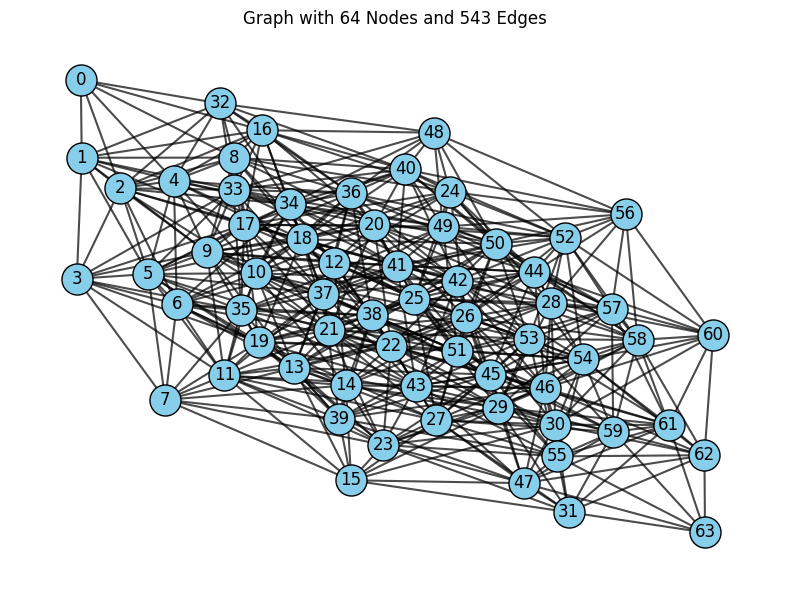

In [19]:
visualize_graph(num_nodes, edges, title=f"Graph with {num_nodes} Nodes and {len(edges)} Edges")

In [20]:
print(model.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Maximum Independent Set

Maximize
 obj: x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9 + x_10 + x_11
      + x_12 + x_13 + x_14 + x_15 + x_16 + x_17 + x_18 + x_19 + x_20 + x_21
      + x_22 + x_23 + x_24 + x_25 + x_26 + x_27 + x_28 + x_29 + x_30 + x_31
      + x_32 + x_33 + x_34 + x_35 + x_36 + x_37 + x_38 + x_39 + x_40 + x_41
      + x_42 + x_43 + x_44 + x_45 + x_46 + x_47 + x_48 + x_49 + x_50 + x_51
      + x_52 + x_53 + x_54 + x_55 + x_56 + x_57 + x_58 + x_59 + x_60 + x_61
      + x_62 + x_63
Subject To
 _edge_constraint_0_1: x_0 + x_1 <= 1
 _edge_constraint_0_2: x_0 + x_2 <= 1
 _edge_constraint_0_4: x_0 + x_4 <= 1
 _edge_constraint_0_8: x_0 + x_8 <= 1
 _edge_constraint_0_16: x_0 + x_16 <= 1
 _edge_constraint_0_32: x_0 + x_32 <= 1
 _edge_constraint_1_2: x_1 + x_2 <= 1
 _edge_constraint_1_3: x_1 + x_3 <= 1
 _edge_constraint_1_4: x_1 + x_4 <= 1
 _edge_constraint_1_5: x_1 + x_5 <= 1
 _edge_constra

### **Classicaly Solve the model**

In [24]:
solution = model.solve()

if solution:
    print("Objective value (size of independent set):", solution.objective_value)
    independent_set = [i + 1 for i in range(num_nodes) if x[i].solution_value > 0.5]  # Convert back to 1-based index
    print("Nodes in the maximum independent set:", independent_set)
else:
    print("No solution found.")

optimal_value = solution.objective_value if solution else None

Objective value (size of independent set): 10.0
Nodes in the maximum independent set: [1, 4, 13, 16, 22, 35, 47, 52, 57, 64]


### **Polytime Preprocessing of MIS**

In [21]:
def find_simplicials(graph):
    """
    Finds simplicial nodes in the graph.
    A node is simplicial if its neighbors form a clique.

    Parameters:
    - graph: networkx.Graph, the input graph.

    Returns:
    - simplicials: list of simplicial nodes.
    """
    simplicials = []
    for node in graph.nodes():
        neighbors = list(graph.neighbors(node))
        is_simplicial = True
        # Check if all pairs of neighbors are connected
        for i in range(len(neighbors)):
            for j in range(i + 1, len(neighbors)):
                if not graph.has_edge(neighbors[i], neighbors[j]):
                    is_simplicial = False
                    break
            if not is_simplicial:
                break
        if is_simplicial:
            simplicials.append(node)
    return simplicials




In [22]:
def preprocess_graph(graph):
    """
    Preprocesses the graph to iteratively remove simplicial nodes
    and their neighbors, and visualizes each step.

    Parameters:
    - graph: networkx.Graph, the input graph.

    Returns:
    - reduced_graph: networkx.Graph, the reduced graph after preprocessing.
    - simplicial_nodes: list of nodes fixed in the independent set.
    - original_indices: dict mapping reduced graph indices to original graph indices.
    """
    pos = nx.spring_layout(graph, seed=42)  # Position for consistent visualization
    iteration = 1
    simplicial_nodes = []  # To keep track of simplicial nodes added to the independent set

    while True:
        current_simplicial_nodes = find_simplicials(graph)
        if not current_simplicial_nodes:
            print(f"No more simplicial nodes found. Preprocessing complete.")
            break  # Stop if no simplicial nodes are found

        print(f"Iteration {iteration}: Found {len(current_simplicial_nodes)} simplicial nodes.")

        # Add simplicial nodes to the independent set
        simplicial_nodes.extend(current_simplicial_nodes)

        # Identify nodes to remove (simplicial nodes and their neighbors)
        neighbors_to_remove = set()
        for node in current_simplicial_nodes:
            neighbors_to_remove.update(graph.neighbors(node))
        nodes_to_remove = set(current_simplicial_nodes).union(neighbors_to_remove)

        # Visualize the current state of the graph
        plt.figure(figsize=(10, 8))
        nx.draw(graph, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=10)
        nx.draw_networkx_nodes(graph, pos, nodelist=current_simplicial_nodes, node_color="red", label="Simplicial Nodes")
        nx.draw_networkx_nodes(graph, pos, nodelist=list(neighbors_to_remove), node_color="yellow", label="Neighbors of Simplicial Nodes")
        plt.title(f"Iteration {iteration}: Removing Simplicial Nodes and Neighbors")
        plt.legend()
        plt.show()

        # Remove the nodes from the graph
        graph.remove_nodes_from(nodes_to_remove)
        iteration += 1

    print(f"Preprocessing complete. Remaining nodes: {list(graph.nodes())}")

    # Create a mapping from reduced graph indices to original indices
    original_indices = {i: node for i, node in enumerate(graph.nodes())}
    return graph, simplicial_nodes, original_indices




In [23]:
def combine_solutions(simplicial_nodes, reduced_solution, original_indices):
    """
    Combines the solution from the simplicial nodes and the reduced graph.

    Parameters:
    - simplicial_nodes: list of nodes fixed in the independent set during preprocessing.
    - reduced_solution: list of nodes in the independent set from the reduced graph solution.
    - original_indices: dict mapping reduced graph indices to original graph indices.

    Returns:
    - full_solution: list of nodes in the full independent set.
    """
    # Map reduced solution back to original graph indices
    mapped_solution = [original_indices[i] for i in reduced_solution]

    # Combine the simplicial nodes with the reduced graph solution
    full_solution = set(simplicial_nodes).union(mapped_solution)
    print(f"Simplicial nodes: {simplicial_nodes}")
    print(f"Reduced graph solution mapped to original indices: {mapped_solution}")
    return sorted(full_solution)

In [25]:
G = nx.Graph()
G.add_edges_from(edges)

print(f"Initial graph has {len(G.nodes)} nodes and {len(G.edges)} edges.")

Initial graph has 64 nodes and 543 edges.


Iteration 1: Found 2 simplicial nodes.


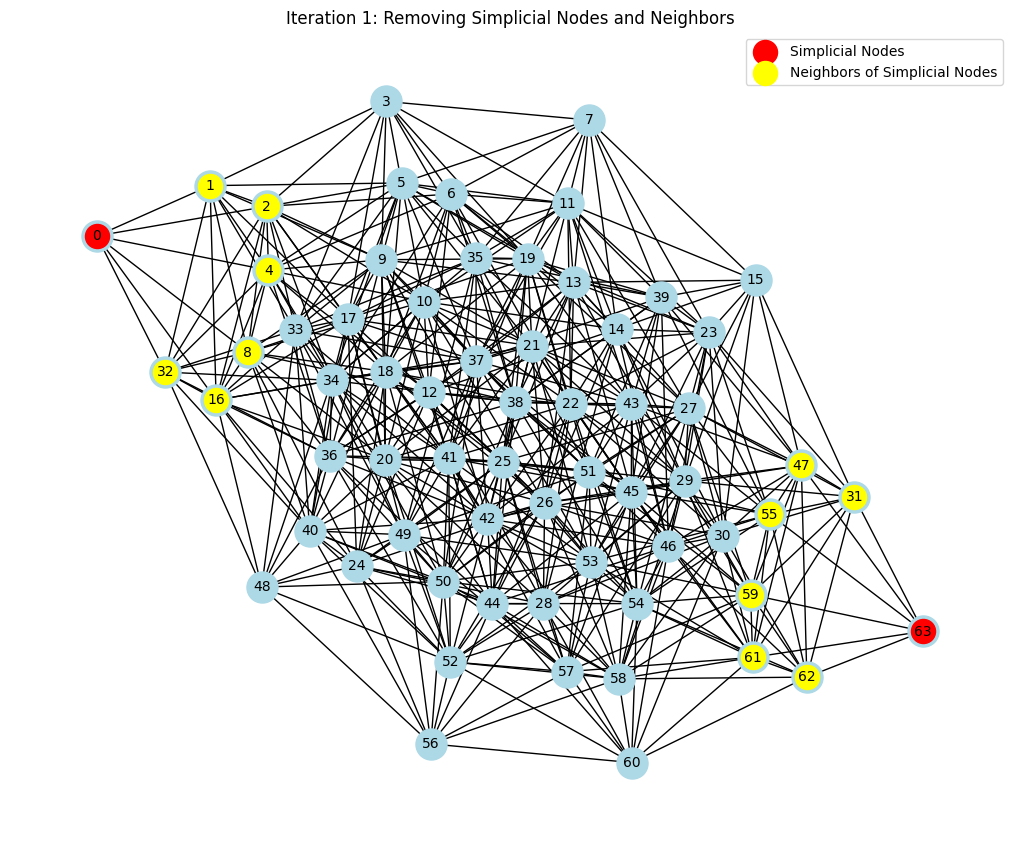

No more simplicial nodes found. Preprocessing complete.
Preprocessing complete. Remaining nodes: [3, 5, 9, 17, 33, 6, 10, 18, 34, 7, 11, 19, 35, 12, 20, 36, 13, 21, 37, 14, 22, 38, 15, 23, 39, 24, 40, 25, 41, 26, 42, 27, 43, 28, 44, 29, 45, 30, 46, 48, 49, 50, 51, 52, 53, 54, 56, 57, 58, 60]
Reduced graph has 50 nodes and 409 edges.


In [26]:
reduced_graph, simplicial_nodes, original_indices = preprocess_graph(G)
print(f"Reduced graph has {len(reduced_graph.nodes)} nodes and {len(reduced_graph.edges)} edges.")

In [27]:
reindexed_graph = nx.convert_node_labels_to_integers(reduced_graph)
model, x = create_max_independent_set_model(len(reindexed_graph.nodes), list(reindexed_graph.edges))

In [28]:
print(model.export_as_lp_string())


\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Maximum Independent Set

Maximize
 obj: x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9 + x_10 + x_11
      + x_12 + x_13 + x_14 + x_15 + x_16 + x_17 + x_18 + x_19 + x_20 + x_21
      + x_22 + x_23 + x_24 + x_25 + x_26 + x_27 + x_28 + x_29 + x_30 + x_31
      + x_32 + x_33 + x_34 + x_35 + x_36 + x_37 + x_38 + x_39 + x_40 + x_41
      + x_42 + x_43 + x_44 + x_45 + x_46 + x_47 + x_48 + x_49
Subject To
 _edge_constraint_0_1: x_0 + x_1 <= 1
 _edge_constraint_0_5: x_0 + x_5 <= 1
 _edge_constraint_0_9: x_0 + x_9 <= 1
 _edge_constraint_0_2: x_0 + x_2 <= 1
 _edge_constraint_0_10: x_0 + x_10 <= 1
 _edge_constraint_0_3: x_0 + x_3 <= 1
 _edge_constraint_0_11: x_0 + x_11 <= 1
 _edge_constraint_0_4: x_0 + x_4 <= 1
 _edge_constraint_0_12: x_0 + x_12 <= 1
 _edge_constraint_1_5: x_1 + x_5 <= 1
 _edge_constraint_1_9: x_1 + x_9 <= 1
 _edge_constraint_1_2: x_1 + x_2 <= 1
 _edge_constraint_1_6: x_1 + x_6 <= 1
 _edge_c

### **Solve the reduced model classically**

In [29]:
solution = model.solve()

reduced_solution = []
if solution:
    print("Objective value (size of independent set):", solution.objective_value)
    reduced_solution = [i for i in range(len(reindexed_graph.nodes)) if x[i].solution_value > 0.5]
    print("Nodes in the reduced graph independent set:", reduced_solution)
else:
    print("No solution found.")


# Combine solutions
full_solution = combine_solutions(simplicial_nodes, reduced_solution, original_indices)
print("Full independent set solution:", full_solution)
print(f"Size of the full independent set: {len(full_solution)}")

Objective value (size of independent set): 8.0
Nodes in the reduced graph independent set: [0, 8, 13, 17, 22, 38, 42, 46]
Simplicial nodes: [0, 63]
Reduced graph solution mapped to original indices: [3, 34, 12, 21, 15, 46, 51, 56]
Full independent set solution: [0, 3, 12, 15, 21, 34, 46, 51, 56, 63]
Size of the full independent set: 10


In [30]:
qp = from_docplex_mp(model)
print(qp.export_as_lp_string()) # make it into a quadratic program

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Maximum Independent Set

Maximize
 obj: x_0 + x_1 + x_2 + x_3 + x_4 + x_5 + x_6 + x_7 + x_8 + x_9 + x_10 + x_11
      + x_12 + x_13 + x_14 + x_15 + x_16 + x_17 + x_18 + x_19 + x_20 + x_21
      + x_22 + x_23 + x_24 + x_25 + x_26 + x_27 + x_28 + x_29 + x_30 + x_31
      + x_32 + x_33 + x_34 + x_35 + x_36 + x_37 + x_38 + x_39 + x_40 + x_41
      + x_42 + x_43 + x_44 + x_45 + x_46 + x_47 + x_48 + x_49
Subject To
 _edge_constraint_0_1: x_0 + x_1 <= 1
 _edge_constraint_0_5: x_0 + x_5 <= 1
 _edge_constraint_0_9: x_0 + x_9 <= 1
 _edge_constraint_0_2: x_0 + x_2 <= 1
 _edge_constraint_0_10: x_0 + x_10 <= 1
 _edge_constraint_0_3: x_0 + x_3 <= 1
 _edge_constraint_0_11: x_0 + x_11 <= 1
 _edge_constraint_0_4: x_0 + x_4 <= 1
 _edge_constraint_0_12: x_0 + x_12 <= 1
 _edge_constraint_1_5: x_1 + x_5 <= 1
 _edge_constraint_1_9: x_1 + x_9 <= 1
 _edge_constraint_1_2: x_1 + x_2 <= 1
 _edge_constraint_1_6: x_1 + x_6 <= 1
 _edge_c

In [31]:
converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)        # converting the quadratic program to qubo

print(qubo.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Maximum Independent Set

Minimize
 obj: - x_0 - x_1 - x_2 - x_3 - x_4 - x_5 - x_6 - x_7 - x_8 - x_9 - x_10 - x_11
      - x_12 - x_13 - x_14 - x_15 - x_16 - x_17 - x_18 - x_19 - x_20 - x_21
      - x_22 - x_23 - x_24 - x_25 - x_26 - x_27 - x_28 - x_29 - x_30 - x_31
      - x_32 - x_33 - x_34 - x_35 - x_36 - x_37 - x_38 - x_39 - x_40 - x_41
      - x_42 - x_43 - x_44 - x_45 - x_46 - x_47 - x_48 - x_49 + [ 102 x_0*x_1
      + 102 x_0*x_2 + 102 x_0*x_3 + 102 x_0*x_4 + 102 x_0*x_5 + 102 x_0*x_9
      + 102 x_0*x_10 + 102 x_0*x_11 + 102 x_0*x_12 + 102 x_1*x_2 + 102 x_1*x_3
      + 102 x_1*x_4 + 102 x_1*x_5 + 102 x_1*x_6 + 102 x_1*x_7 + 102 x_1*x_8
      + 102 x_1*x_9 + 102 x_1*x_10 + 102 x_1*x_11 + 102 x_1*x_12 + 102 x_1*x_16
      + 102 x_1*x_17 + 102 x_1*x_18 + 102 x_2*x_3 + 102 x_2*x_4 + 102 x_2*x_6
      + 102 x_2*x_7 + 102 x_2*x_10 + 102 x_2*x_11 + 102 x_2*x_13 + 102 x_2*x_14
      + 102 x_2*x_15 + 102 x_2*x

In [32]:
# number of variables
num_vars = qubo.get_num_vars()
print('Number of variables:', num_vars)

Number of variables: 50


In [33]:
# basic imports

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# quantum imports

from qiskit.circuit import Parameter,QuantumCircuit
from qiskit_optimization.translators import from_docplex_mp

from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.quantum_info import Pauli, SparsePauliOp, Statevector
# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2



# SciPy minimizer routine
from scipy.optimize import minimize
from qiskit.primitives import BackendEstimatorV2, BackendSamplerV2
from qiskit_aer import AerSimulator
backend = AerSimulator(method='matrix_product_state')


estimator = BackendEstimatorV2(backend=backend)
sampler = BackendSamplerV2(backend=backend)

In [34]:
num_vars = qubo.get_num_vars()
print(f"Number of variables: {num_vars}")

Number of variables: 50


In [37]:
qubitOp, offset = qubo.to_ising()
ansatz = EfficientSU2(qubitOp.num_qubits)
print(f"Ansatz circuit depth: {ansatz.depth()}")


Ansatz circuit depth: 1


In [38]:
num_params = ansatz.num_parameters
num_params


400

In [39]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (EstimatorV2): Estimator primitive instance
        cost_history_dict: Dictionary for storing intermediate results

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = params
    cost_history_dict["cost_history"].append(energy)
    print(f"Iters. done: {cost_history_dict['iters']} [Current cost: {energy}]")

    return energy

In [40]:
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

In [41]:
x0 = 2 * np.pi * np.random.random(num_params)


In [42]:
ansatz = ansatz.decompose()

res = minimize(
        cost_func,
        x0,
        args=(ansatz, qubitOp, estimator),
        method="cobyla",
    )

Iters. done: 1 [Current cost: -35.179443359375]
Iters. done: 2 [Current cost: 42.719482421875]
Iters. done: 3 [Current cost: -53.353515625]
Iters. done: 4 [Current cost: -24.431640625]
Iters. done: 5 [Current cost: -86.588134765625]
Iters. done: 6 [Current cost: -63.4296875]
Iters. done: 7 [Current cost: -76.029541015625]
Iters. done: 8 [Current cost: -108.612548828125]
Iters. done: 9 [Current cost: -115.496826171875]
Iters. done: 10 [Current cost: -89.712646484375]
Iters. done: 11 [Current cost: -79.991943359375]
Iters. done: 12 [Current cost: -68.091796875]
Iters. done: 13 [Current cost: -87.911865234375]
Iters. done: 14 [Current cost: -82.7900390625]
Iters. done: 15 [Current cost: -60.551513671875]
Iters. done: 16 [Current cost: -7.649169921875]
Iters. done: 17 [Current cost: -100.7392578125]
Iters. done: 18 [Current cost: -123.11669921875]
Iters. done: 19 [Current cost: -147.7138671875]
Iters. done: 20 [Current cost: -196.74462890625]
Iters. done: 21 [Current cost: -178.60913085937

In [43]:
res

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1556.20654296875
       x: [ 5.351e+00  4.243e+00 ...  5.989e+00  3.100e+00]
    nfev: 1000
   maxcv: 0.0

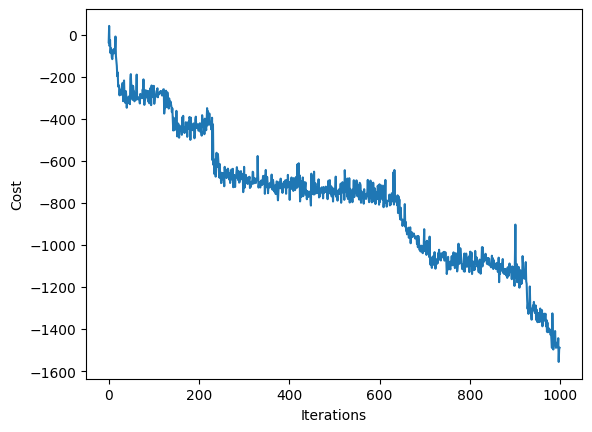

In [44]:
fig, ax = plt.subplots()
ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [45]:
ansatz = ansatz.assign_parameters(res.x)
ansatz.measure_all()
ansatz.draw("mpl", style="iqp",fold=-1)

MissingOptionalLibraryError: "The 'pylatexenc' library is required to use 'MatplotlibDrawer'. You can install it with 'pip install pylatexenc'."

In [46]:
pub = (ansatz,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}

In [47]:
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, num_vars)
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


In [48]:
# Find the indices of the top 4 values
top_4_indices = np.argsort(np.abs(values))[::-1][:4]
top_4_results = []
# Print the top 4 results with their probabilities
print("Top 4 Results:")
for idx in top_4_indices:
    bitstring = to_bitstring(keys[idx], num_vars)
    bitstring.reverse()
    top_4_results.append(bitstring)
    print(f"Bitstring: {bitstring}, Probability: {values[idx]:.6f}")

Top 4 Results:
Bitstring: [1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], Probability: 0.000100
Bitstring: [1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0], Probability: 0.000100
Bitstring: [0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], Probability: 0.000100
Bitstring: [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], Probability: 0.000100


In [49]:
result = converter.interpret(most_likely_bitstring)
cost = qp.objective.evaluate(result)
feasible =qp.get_feasibility_info(result)[0]


print("Result MIS", result)
print("Result value:", cost)
print("Feasible:", feasible)

Result MIS [1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 0.]
Result value: 22.0
Feasible: False


In [50]:
# Iterate through the list of bitstrings and evaluate for each
for bitstring in top_4_results:
    result = converter.interpret(bitstring)  # Interpret the bitstring
    cost = qp.objective.evaluate(result)  # Evaluate the cost for the bitstring
    feasible =qp.get_feasibility_info(result)[0]
    
    # Print the results
    print("Result MIS:", result)
    print("Result value:", cost)
    print("Feasible solution:", feasible)

Result MIS: [1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1.
 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0.]
Result value: 18.0
Feasible solution: False
Result MIS: [1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0.]
Result value: 19.0
Feasible solution: False
Result MIS: [0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0.]
Result value: 19.0
Feasible solution: False
Result MIS: [1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0.
 0. 0.]
Result value: 17.0
Feasible solution: False
